# Challenge 1: Agriculture Commodities, Prices & Seasons
 Aim: Your team is working on building a variety of insight packs to measure key trends in the Agriculture sector in India. You are presented with a data set around Agriculture and your aim is
to understand trends in APMC (Agricultural produce market committee)/mandi price & quantity
arrival data for different commodities in Maharashtra.
Objective:
1. Test and filter outliers.
2. Understand price fluctuations accounting the seasonal effect
1. Detect seasonality type (multiplicative or additive) for each cluster of APMC and
commodities
2. De-seasonalise prices for each commodity and APMC according to the detected
seasonality type
3. Compare prices in APMC/Mandi with MSP(Minimum Support Price)- raw and
deseasonalised
4. Flag set of APMC/mandis and commodities with highest price fluctuation across different
commodities in each relevant season, and year.

Variable description:
1. msprice- Minimum Support Price
2. arrivals_in_qtl- Quantity arrival in market (in quintal)
3. min_price- Minimum price charged per quintal
4. max_price- Maximum price charged per quintal
5. modal_price- Mode (Average) price charged per quintal

In [379]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [370]:
data_1 = pd.read_csv("CMO_MSP_MANDI.csv")
data_1.head()

,commodity,year,Type,msprice,msp_filter
0,PADDY-UNHUSKED,2012,Kharif Crops,1250.0,1
1,RICE(PADDY-HUS),2012,Kharif Crops,1280.0,1
2,Jowar_Hybrid,2012,Kharif Crops,1500.0,1
3,SORGUM(JAWAR),2012,Kharif Crops,1520.0,1
4,BAJRI,2012,Kharif Crops,1175.0,1


## Data Exploration

In the below cell, we are displaying the description of the CMO_MSP_MANDI data. 

In [380]:
data_1.describe(include = "all")

,commodity,year,Type,msprice,msp_filter
count,155,155.000000,155,145.000000,155.0
unique,32,NaN,3,NaN,NaN
top,SUNFLOWER,NaN,Kharif Crops,NaN,NaN
freq,5,NaN,90,NaN,NaN
mean,NaN,2014.000000,NaN,2822.448276,1.0
std,NaN,1.418798,NaN,1441.725928,0.0
min,NaN,2012.000000,NaN,170.000000,1.0
25%,NaN,2013.000000,NaN,1470.000000,1.0
50%,NaN,2014.000000,NaN,2970.000000,1.0
75%,NaN,2015.000000,NaN,4000.000000,1.0


 Below two cells are showing the distribution of msprice in the respective years and histogram distribution of msprice respectively.

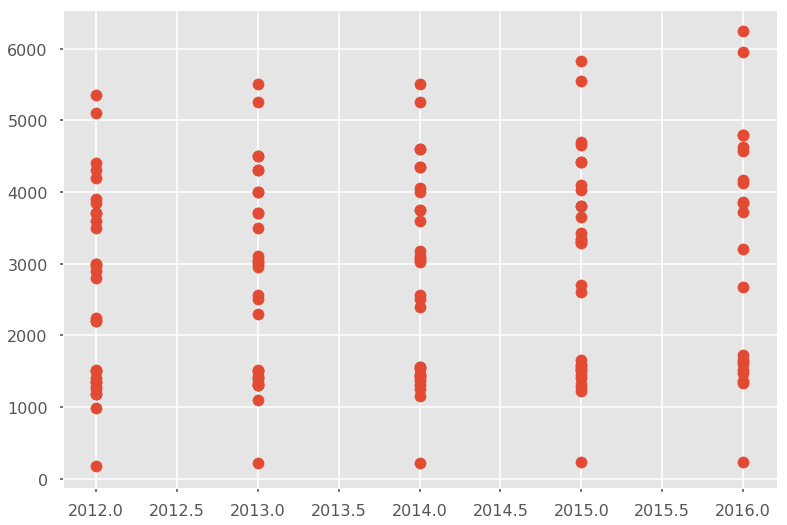

In [382]:
plt.scatter(data_1["year"], data_1["msprice"])

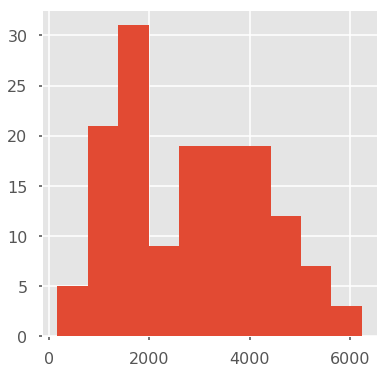

In [391]:
data_1["msprice"].hist(bins=10,figsize=[6,6])

In [406]:
#list of unique commodities and years

unique_commodity = list(data_1["commodity"].unique())
unique_year = list(data_1["year"].unique())
print("No of unique commodity in CMO_MSP_Mandi: ", len(unique_commodity))
print("No of unique years CMO_MSP_Mandi: ", len(unique_year))

No of unique commodity in CMO_MSP_Mandi:  32
No of unique years CMO_MSP_Mandi:  5


In [282]:
data_2 = pd.read_csv("Monthly_data_cmo (1).csv")
data_2["date"] = pd.to_datetime(data_2["date"])
data_2.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
0,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,2015-04-01,Ahmadnagar,Maharashtra
1,Ahmednagar,Bajri,2016,April,106,1788,1925,1875,2016-04-01,Ahmadnagar,Maharashtra
2,Ahmednagar,Wheat(Husked),2015,April,1253,1572,1890,1731,2015-04-01,Ahmadnagar,Maharashtra
3,Ahmednagar,Wheat(Husked),2016,April,387,1750,2220,1999,2016-04-01,Ahmadnagar,Maharashtra
4,Ahmednagar,Sorgum(Jawar),2015,April,3825,1600,2200,1900,2015-04-01,Ahmadnagar,Maharashtra


In [398]:
data_2.describe(include = "all")

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
count,62429,62429,62429.000000,62429,6.242900e+04,6.242900e+04,6.242900e+04,62429.000000,62429,62429,62429
unique,349,352,NaN,12,NaN,NaN,NaN,NaN,27,33,1
top,Mumbai,Gram,NaN,November,NaN,NaN,NaN,NaN,2016-01-01 00:00:00,Pune,Maharashtra
freq,1538,3972,NaN,7183,NaN,NaN,NaN,NaN,2769,6366,62429
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-09-01 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-01 00:00:00,NaN,NaN
mean,NaN,NaN,2015.337503,NaN,6.043088e+03,2.945228e+03,3.688814e+03,3296.003989,NaN,NaN,NaN
std,NaN,NaN,0.690451,NaN,3.470331e+04,1.318396e+04,7.662962e+03,3607.792534,NaN,NaN,NaN
min,NaN,NaN,2014.000000,NaN,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,NaN
25%,NaN,NaN,2015.000000,NaN,3.800000e+01,1.250000e+03,1.600000e+03,1450.000000,NaN,NaN,NaN


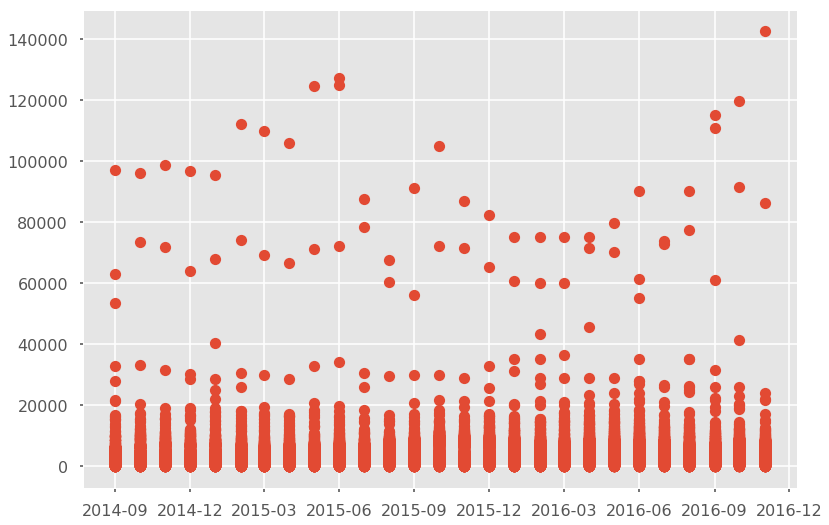

In [393]:
plt.plot_date(data_2["date"], data_2["modal_price"])

In the above cell, we can clearly see that there are some modal prices present in the respective years which are very high in value as compared to other modal prices

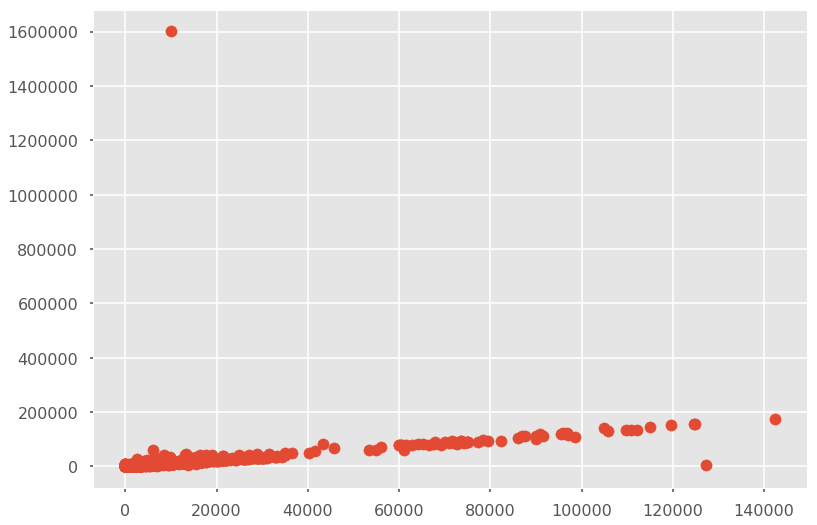

In [397]:
plt.scatter(data_2["modal_price"], data_2["max_price"])

In the above scatter plot between modal_price and max_price, we can clearly see that there is a linear relationship between them

In [5]:
#list of unique commodity, years and APMC

apmc = list(data_2["APMC"].unique())
comm = list(data_2["Commodity"].unique())
years = list(data_2["Year"].unique())
print("No of unique APMC: ", len(apmc))
print("No of unique comm: ", len(comm))
print("No of unique years: ", len(years))

No of unique APMC:  349
No of unique comm:  352
No of unique years:  3


## Outlier detection

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, we will implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Remove data points from the dataset by adding indices to the `outliers` list.


In [6]:
# outlier detection
count = 0
index_values = []
for i in range(len(comm)):
    for j in range(len(years)):
        count = count+1
        df = data_2[(data_2["Commodity"] == comm[i]) & (data_2["Year"] == years[j])]
        if len(df)>0:
            Q1 = np.percentile(df["modal_price"], 25)
            Q3 = np.percentile(df["modal_price"], 75)
            step = 1.5*(Q3 - Q1)
            outlier_values = df[~(df["modal_price"] >= Q1 - step) & (df["modal_price"] <= Q3 + step)]
            index_values = index_values + list(outlier_values.index)
            #display(outlier_values)

In [7]:
# printing outliers
print("No of outliers detected: ", len(index_values))

No of outliers detected:  617


As we can see that there are 617 data points which are outliers. So we will simply drop them from the data. In the below cell, I have dropped the outliers and stored them in the "good_data"

In [410]:
# Removing outliers
good_data = data_2.drop(data_2.index[index_values]).reset_index(drop = True)
good_data.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
0,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,2015-04-01,Ahmadnagar,Maharashtra
1,Ahmednagar,Bajri,2016,April,106,1788,1925,1875,2016-04-01,Ahmadnagar,Maharashtra
2,Ahmednagar,Wheat(Husked),2015,April,1253,1572,1890,1731,2015-04-01,Ahmadnagar,Maharashtra
3,Ahmednagar,Wheat(Husked),2016,April,387,1750,2220,1999,2016-04-01,Ahmadnagar,Maharashtra
4,Ahmednagar,Sorgum(Jawar),2015,April,3825,1600,2200,1900,2015-04-01,Ahmadnagar,Maharashtra


In [424]:
good_data.to_csv("outlier_removed_data.csv", index = False)

## Preprocessing data

As we have removed the outliers, our next task is to determine the type of seasonality (Additive/Multiplicative). Before detecting seasonality we will first preprocess our data. In the below cell, I have implement the following steps:

1. Add a column containing the combined information of APMC and commodity names.
2. Then groupby the data by APMC, Commodity, Year and APMC/Commodity.
3. Filtering the data to having at least 12 distinct prices for a commodity, to constitute a time-series of data.
4. Storing the preprocces data into csv file named "preprocess_data.csv".

In [216]:
#Preprocessing the data for detecting seasonality

good_data["APMC/Commodity"] = good_data["APMC"] + "," + good_data["Commodity"]
data=good_data[["APMC","Commodity","modal_price","Year","APMC/Commodity"]].groupby(["APMC","Commodity","Year",
            "APMC/Commodity"],as_index=False).count().rename(columns={"modal_price":"modal_price_Count"}).reset_index(drop=True)
data_3 = data[data['modal_price_Count'] == 12].reset_index(drop=True)

distinct_APMC_commodity = data_3["APMC/Commodity"].unique().tolist()
new_data = good_data[good_data["APMC/Commodity"].isin(distinct_APMC_commodity)].reset_index(drop = True)

c:\users\dheeraj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'APMC' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """
c:\users\dheeraj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'Commodity' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """
c:\users\dheeraj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'Year' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """


In [10]:
new_data.to_csv("preprocess_data.csv", index = False)

## Seasonality detection

Now as we have obtained our preprocess data. We will now find the seasonality in our data. In the below cell I have first read the data and then I have converted the date column by using to_datetime method in pandas. I have also filter out the values whose model_price is equal to zero.

In [367]:
data_seasonal = pd.read_csv("preprocess_data.csv")
data_seasonal["date"]=pd.to_datetime(data_seasonal["date"])
drop_index = data_seasonal[data_seasonal["modal_price"] == 0].index
data_seasonal = data_seasonal.drop(data_seasonal.index[[drop_index]])
data_seasonal.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name,APMC/Commodity
0,Akole,Bajri,2015,April,52,1357,1800,1525,2015-04-01,Ahmadnagar,Maharashtra,"Akole,Bajri"
1,Akole,Bajri,2016,April,75,1460,1960,1685,2016-04-01,Ahmadnagar,Maharashtra,"Akole,Bajri"
2,Akole,Paddy-Unhusked,2015,April,113,1450,1925,1625,2015-04-01,Ahmadnagar,Maharashtra,"Akole,Paddy-Unhusked"
3,Akole,Paddy-Unhusked,2016,April,448,1500,2017,1704,2016-04-01,Ahmadnagar,Maharashtra,"Akole,Paddy-Unhusked"
4,Akole,Wheat(Husked),2015,April,164,1450,1975,1644,2015-04-01,Ahmadnagar,Maharashtra,"Akole,Wheat(Husked)"


Now in order to check whether the time series is stationary or not, we will plot the autocoorelation function. This will help us in identifying whether the current price is dependent upon the prices at some prior times or not. 

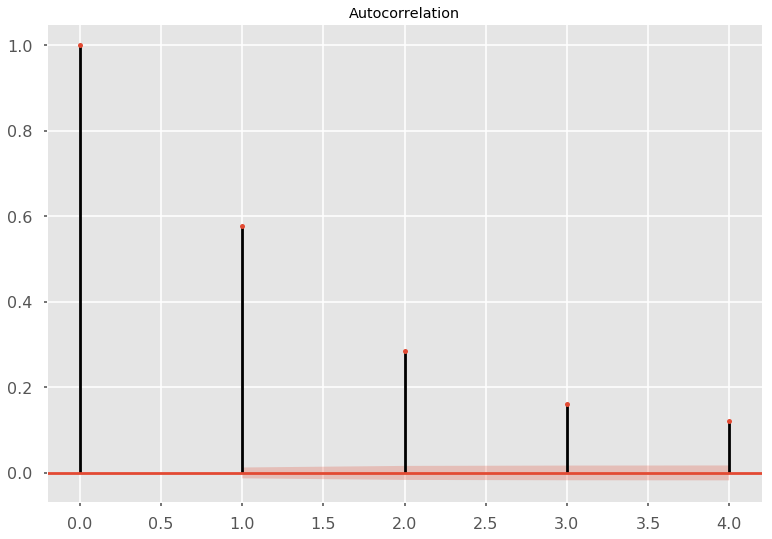

In [411]:
#Autocorrelation check for modal price
a = plot_acf(data_seasonal["modal_price"], lags = 4)

Form the above autocorrelation plot, as the correlation values are decreasing with time it is clear that there is time dependent patter in our time series.

Now we will perform Augmented Dickey-Fuller (ADF) test. This test will yields a p-value under the null hypothesis of non-stationarity. A p-value of <0.05 therefore signifies stationarity.

In [375]:
from statsmodels.tsa.stattools import adfuller
def adf_test(y):
    # perform Augmented Dickey Fuller test
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)
 
# apply the function to the time series
adf_test(s["modal_price"])

Results of Augmented Dickey-Fuller test:
test statistic          -1.548406
p-value                  0.509444
# of lags                0.000000
# of observations       25.000000
Critical Value (1%)     -3.723863
Critical Value (5%)     -2.986489
Critical Value (10%)    -2.632800
dtype: float64


As we can clearly see that the value of p i.e p = 0.509 is much larger than 0.05, therefor it confirms that our time series is non stationary and there is some seasonality present in our data.

Now, as we have confirmed that our data is non stationary, we will detect the type of seasonality i.e whether it is additive or multiplicative. We will do this in following steps:
1. We will perform seasonal decomposition on the modal_prices. Additive decomposition is (time series = trend + seasonality + white noise) while multiplicative decomposition is (time series = trend x seasonality x white noise). Trend is how things are overall changing. Seasonality how things change within a given period e.g. a year, month, week, day. Error/residual/irregular activity not explained by the trend or the seasonal value. In order to perform decomposition I have used seasonal_decompose from statsmodel.
2. After performing seasonal decomposition, we have to find type of seasonality. To this I have taken help of autocorrealtion function. I have first obtain the residual values from both the type of seasonal decomposition, then I have check the whether how much correlation between data points is still encoded within the residuals. As some of the correlations could be negative I have select the type with the smallest sum of squares of correlation values.
3. After finding the type of seasonality, I have deseasonalised them. If seasonality is additive, then I have taken the difference of modal price values and seasonal values. If seasonality is multiplicative, then I have divide the modal price vlaues by seasonal values.

In [53]:
def detect_type_of_seasonality_and_deseasonalise(data,distinct_APMC_commodity):
    season_dict = {}
    frames = []
    for i in range(len(distinct_APMC_commodity)):
        n_data =  data[data["APMC/Commodity"] == distinct_APMC_commodity[i]]
        comm_data = n_data
        comm_data.index = comm_data["date"]
        comm_data = comm_data.resample("m").mean()
        comm_data = comm_data.fillna(int(comm_data['modal_price'].mean()))
        try:
            decomposition_add = seasonal_decompose(comm_data["modal_price"], model="additive", freq = 12)
            decomposition_mult = seasonal_decompose(comm_data["modal_price"], model="multiplicative", freq = 12)
            residue_add = sum(np.square(acf(decomposition_add.resid, missing = "drop")))
            residue_mult = sum(np.square(acf(decomposition_mult.resid, missing = "drop")))
        except:
            try:
                decomposition_add = seasonal_decompose(comm_data["modal_price"], model="additive", freq = 6)
                decomposition_mult = seasonal_decompose(comm_data["modal_price"], model="multiplicative", freq = 6)
                residue_add = sum(np.square(acf(decomposition_add.resid, missing = "drop")))
                residue_mult = sum(np.square(acf(decomposition_mult.resid, missing = "drop")))    
            except: 
                print("***************************************************************")
                decomposition_add = seasonal_decompose(comm_data["modal_price"], model="additive", freq = 2)
                decomposition_mult = seasonal_decompose(comm_data["modal_price"], model="multiplicative", freq = 2)
                residue_add = sum(np.square(acf(decomposition_add.resid, missing = "drop")))
                residue_mult = sum(np.square(acf(decomposition_mult.resid, missing = "drop")))
        
        if residue_add < residue_mult:
            
            comm = distinct_APMC_commodity[i]
            season_dict[comm] = "Additive" 
            comm_data['Seasonal'] = decomposition_add.seasonal.values
            values=comm_data["modal_price"]-comm_data['Seasonal']
            values=values.tolist()
            indexes=n_data.index.tolist()
            values_range=range(0,len(values))
            for index,value in zip(indexes,values_range):
                n_data.at[index,"deseasonalise_price"]=values[value]
            n_data["seasonality_type"] = "Additive"
            frames.append(n_data)
            
        else:
            
            comm = distinct_APMC_commodity[i]
            season_dict[comm] = "multiplicative"
            comm_data['Seasonal'] = decomposition_mult.seasonal.values
            values=comm_data["modal_price"]/comm_data['Seasonal']
            values=values.tolist()
            indexes=n_data.index.tolist()
            values_range=range(0,len(values))
            for index,value in zip(indexes,values_range):
                n_data.at[index,"deseasonalise_price"]=values[value]
            n_data["seasonality_type"] = "multiplicative"
            frames.append(n_data)
            
    deseason_data = pd.concat(frames).reset_index(drop = True)
    return deseason_data, season_dict

In [54]:
m,n = detect_type_of_seasonality_and_deseasonalise(data_seasonal,distinct_APMC_commodity )

c:\users\dheeraj\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\dheeraj\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\users\dheeraj\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

***************************************************************
***************************************************************


Now above function returns deseasonalised data and a dictionary of commodities and type of seasonality present in them. I have stored them in the csv files names "deseasonalised_data.csv" and "Seasonal_type_list.csv" respectively.

In [55]:
m.to_csv("deseasonalised_data.csv",index = False )

In [75]:
seasonal_types = pd.DataFrame.from_dict(n, orient='index')
seasonal_types["APMC/Commodity"] = list(seasonal_types.index)
seasonal_types = seasonal_types.reset_index(drop = True)
seasonal_types.columns = ["Type", "APMC/Commodity"]
seasonal_types.to_csv("Seasonal_type_list.csv",index = False )

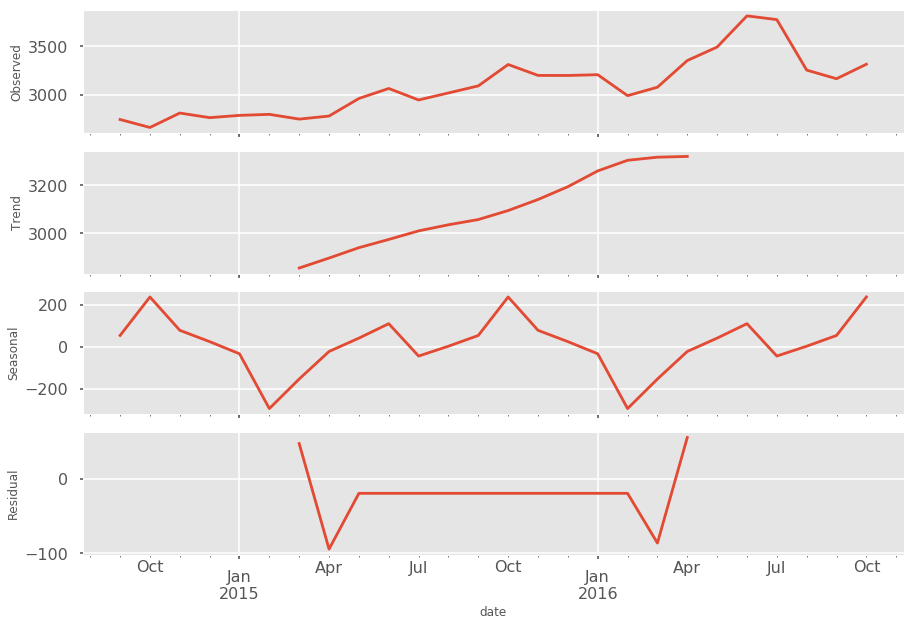

In [422]:
# just an example of how additive decomposition on whole data looks like.
s = data_seasonal
s.index = s["date"]
s = s.resample("m").mean()
s = s.fillna(int(s['modal_price'].mean()))
decompose_additive = seasonal_decompose(s["modal_price"], model="additive", freq=12).plot()

### Flag set of APMC/mandis and commodities with highest price fluctuation across different commodities in each relevant season, and year

Now our next task is to flag set the price fluctuations. I have first include only year to find the fluctuations. To do this I have performed following steps:
1. I have add a new column which contain the absolute fluctutaions. Absolute fluctuation is the difference of max_price and min_price.
2. Then I added another column which contain relative fluctuations. 
3. Then I have grouped the data by APMC, Commodity and Year. 
4. After this I have just reordered the data by sorting the absolute fluctuations to find the highest price fluctuations accross different commodities in each relevant year.

In [222]:
flag_data = good_data
flag_data["absolute_fluctuation"] = flag_data["max_price"] - flag_data["min_price"]
flag_data["relative_fluctuation"] = (flag_data["absolute_fluctuation"] *100)/flag_data["min_price"]

In [223]:
flag_data = flag_data[["APMC","Commodity","Year","min_price","max_price","absolute_fluctuation","relative_fluctuation"]].groupby(["APMC", "Year", "Commodity"],as_index=False).apply(lambda x: x.sort_values(by = 'absolute_fluctuation', ascending = False)).reset_index(drop=True)
flag_data.head()

,APMC,Commodity,Year,min_price,max_price,absolute_fluctuation,relative_fluctuation
0,Aamgaon,Paddy-Unhusked,2014,1645,1843,198,12.036474
1,Aamgaon,Paddy-Unhusked,2014,1591,1749,158,9.930861
2,Aamgaon,Paddy-Unhusked,2014,1438,1577,139,9.666203
3,Aamgaon,Paddy-Unhusked,2014,1481,1554,73,4.929102
4,Aamgaon,Paddy-Unhusked,2015,1459,1555,96,6.579849


In [224]:
# data showing highest price fluctuations.
flag_data = flag_data.sort_values(by = ["absolute_fluctuation"], ascending = False).reset_index(drop = True)
flag_data.head()

,APMC,Commodity,Year,min_price,max_price,absolute_fluctuation,relative_fluctuation
0,Atpadi,Goats,2016,4000,1600090,1596090,39902.250000
1,Mumbai,Cashewnuts,2015,70000,140000,70000,100.000000
2,Mumbai,Cardamom,2016,86471,152941,66470,76.869702
3,Sangli-Phale Bhajipalam,Mango,2016,17422,83075,65653,376.839628
4,Mumbai,CARDAMOM,2016,110313,174375,64062,58.072938


In [412]:
flag_data.to_csv("flag_set_data_year.csv", index = False)

Now we will include both year and seasons. There are three types of crops present in the CMO_MSP_MANDI data which are "Kharif crops", "Rabi crops" and "other crops". We will include only those commodities which are present in both CMO_MSP_MANDI data and monthly_cmo_data. And then we will find the highest price fluctuations. 

In [415]:
flag_data_year_season = flag_data[flag_data["Commodity"].isin(unique_commodity)].reset_index(drop = True)
flag_data_year_season.head()

,APMC,Commodity,Year,min_price,max_price,absolute_fluctuation,relative_fluctuation
0,Mumbai,RICE(PADDY-HUS),2016,4562,9381,4819,105.633494
1,Sangali,RICE(PADDY-HUS),2016,2164,5586,3422,158.133087
2,Solapur,RICE(PADDY-HUS),2016,2265,5300,3035,133.995585
3,Karjat (Raigad),RICE(PADDY-HUS),2016,2000,5022,3022,151.100000
4,Kolhapur-Laxmipuri,RICE(PADDY-HUS),2016,2100,4910,2810,133.809524


It is clearly visible that if we inculde only year then the price fluctuations are high but when we taken account of both season and year fluctuations are low as compare to that of previous one. Now we will write this data in a csv file named "flag_data_year_season.csv".

In [416]:
flag_data_year_season.to_csv("flag_data_year_season.csv", index = False)

## Compare prices in APMC/Mandi with MSP(Minimum Support Price)- raw and deseasonalised

Now we have to compare prices. In the below cell, I have compare the prices of Aamgaon APMC having "Paddy-unhusked" as a commodity. We can compare the prices of other commodities and APMC as well. To that, we have to just change the APMC and Commodity names in the below cell.

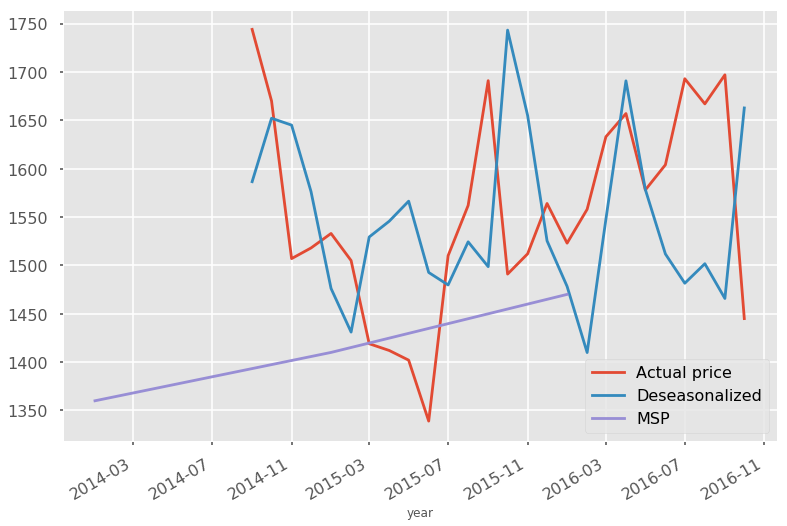

In [421]:
#Plottig the price of bajri 
raw_Paddy_Unhusked = data_2[(data_2["APMC"] == "Aamgaon") & (data_2["Commodity"] == "Paddy-Unhusked")].reset_index(drop = True)
deseason_Paddy_Unhusked = m[(m["APMC/Commodity"] == "Aamgaon,Paddy-Unhusked") & (m["deseasonalise_price"] > 0)].reset_index(drop = True)
msp_Paddy_Unhusked = data_1[(data_1["commodity"] == "PADDY-UNHUSKED") & (data_1["year"] > 2013)].reset_index(drop = True)
msp_Paddy_Unhusked["year"]=pd.to_datetime(msp_Paddy_Unhusked["year"], format= '%Y')
raw_Paddy_Unhusked.index = raw_Paddy_Unhusked["date"]
deseason_Paddy_Unhusked.index = deseason_Paddy_Unhusked["date"]
msp_Paddy_Unhusked["year"] = pd.to_datetime(msp_Paddy_Unhusked["year"])
msp_Paddy_Unhusked.index = msp_Paddy_Unhusked["year"]
raw_Paddy_Unhusked["modal_price"].plot()
deseason_Paddy_Unhusked["deseasonalise_price"].plot()
msp_Paddy_Unhusked["msprice"].plot()
plt.legend(['Actual price', 'Deseasonalized', 'MSP'])